# Hyperspec

In [1]:
import hyperspy.api as hs                 # hyperspectral data processing and some useful image viewing
import h5py                               # to handle .h5 files
from matplotlib import pyplot as plt      # Plotting
import numpy as np                        # Maths
import cv2                                # Image analysis
from os import walk                       # To get filepaths automatically
from natsort import natsorted             # To easily resort file order
from datetime import datetime             # For easily parsing timestamps
import warnings
warnings.filterwarnings("ignore")         # Attempt to remove some unnecessary pyplot warnings
from scipy.optimize import curve_fit
import pandas as pd
from pathlib import Path
import optical_image_functions as oif

Set folder location of data.

In [2]:
#folder=r'C:\Users\es758\University of Cambridge\Alice Dearle - mini1 hyper-perov\example 2 hyperspectral\090321\\'
folder=r'C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\example 2 hyperspectral\090321\\'
fpaths = oif.get_filepaths(folder)

The hyperspectral microscope in MRC has software which outputs 2 files per time step, one being a rectified image stack which is what is wanted. The code below extracts the file paths for these rectified images alone.

In [3]:
rectified_fpaths = []
for fpath in fpaths:
    if fpath[-9:] == "(1)(1).h5":
        rectified_fpaths.append(fpath)

Inspect some of the properties of each image stack, and extract the pixel size.

In [4]:
fpath=rectified_fpaths[0]
print(fpath)
f = h5py.File(fpath,'r')
# Extract the image
print("Number of wavelengths per time step", len(f['Cube/Wavelength']))
pixel_size = oif.get_pixel_size(fpath)
print("Pixel size is", pixel_size, "µm/pixel")

C:\Users\Sauron\Documents\grl31\NanoDTC Mini - Edward\example 2 hyperspectral\090321\\Untitled(1)(1).h5
Number of wavelengths per time step 26
Pixel size is 0.325 µm/pixel


For further information of what each h5py file contains.

In [5]:
# oif.get_h5py_contents(fpath)

## Extract and Shape Data

In [6]:
def extract_h5py_image_stack(fpath):
    """
    Extracts hyperspectral data from h5y file and forms it into a hyperspy object.
    Data is returned as a hyperspy 2D signal (stack of images of different wavelengths).
    Data can be easily converted to 1D signal (wavelength spectrum at each pixel) by transposing the object.
    """
    f = h5py.File(fpath,'r')
    
    pixel_size = oif.get_pixel_size(fpath)
    
    wavelengths=np.array(f['Cube/Wavelength'])
    dwavelength=wavelengths[1]-wavelengths[0]
    images = np.array(f['Cube/Images']).astype("float32")
    
    lam_size, y_size, x_size = images.shape
    
    dictlam = {'size': lam_size, 'name':'lambda', 'units':'nm', 'scale':dwavelength, 'offset':wavelengths[0]}
    dicty = {'size': y_size, 'name':'y', 'units':'µm', 'scale':pixel_size, 'offset':0} # Note y still increases as go down the image
    dictx = {'size': x_size, 'name':'x', 'units':'µm', 'scale':pixel_size, 'offset':0}

    image_stack = hs.signals.Signal2D(images, axes =[dictlam, dicty, dictx])
    return image_stack

In [7]:
def extract_h5py_hyperspec_data(fpaths):
    """
    
    Could add an option to make time a navigation axis too.
    """
    image_stacks=[]
    ts = []
    time = 0
    for fpath in fpaths:
        image_stack = extract_h5py_image_stack(fpath)
        f = h5py.File(fpath,'r')
        image_stacks.append(image_stack)
        ts.append(time) # Don't know for now
        time += 1 
    image_stacks=np.array(image_stacks)
    ts=np.array(ts)
    
    
    fpath=fpaths[0]
    f = h5py.File(fpath,'r')
    wavelengths = np.array(f['Cube/Wavelength'])
    
    return image_stacks, ts, wavelengths

In [8]:
def convert_signal_dimensions(signal):
    """
    Have included so can change later if want to make more complicated signal e.g., with time axis included.
    """
    signal_transposed=signal.transpose()
    return signal_transposed

In [9]:
images_2D, ts, wavelengths = extract_h5py_hyperspec_data(rectified_fpaths)

Create a set of the data as 1D images.

In [ ]:
images_1D = np.array([convert_signal_dimensions(image_stack) for image_stack in images_2D])

### Inspecting how the data is stored.

Be wary of operating on signal data directly without taking copies. Safer to create a copy first if going to do processing outside of hyperspy tools.

2D Signal Images:

In [ ]:
%matplotlib qt

fpath=rectified_fpaths[0]
test_image_stack = extract_h5py_image_stack(fpath)
test_image_stack.plot(navigator='auto')
test_image_stack.axes_manager
plt.show()

(26, 1024, 1024)
(1024, 1024)
(1024, 1024)


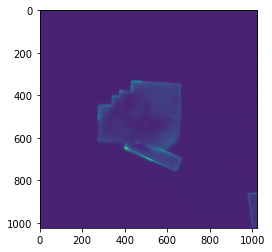

In [65]:
%matplotlib inline
print(test_image_stack.data.shape)
print(test_image_stack.data[7][:][:].shape)
test=test_image_stack.data[24][:][:]
print(test.shape)
plt.imshow(test)

1D signal images:

In [ ]:
%matplotlib qt

slider = False

fpath=rectified_fpaths[0]
test_image_stack = extract_h5py_image_stack(fpath)
im_1d = test_image_stack.transpose()

if slider == False:
    im_1d=im_1d.rebin(scale=[8,8,1])
    im_1d.plot(navigator='auto')
elif slider == True:
    im_1d.plot(navigator='auto')
im_1d.axes_manager

(1024, 1024, 26)
(1024, 26)
(1024, 1024)


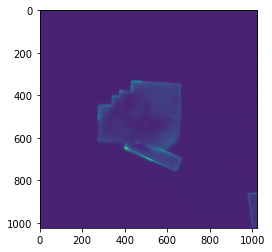

In [66]:
%matplotlib inline
print(im_1d.data.shape)
print(im_1d.data[0].shape)
test=im_1d.data[:][:]
print(test[:,:,0].shape)
plt.imshow(test[:,:,24])

## Peak Wavelength Shift

In [ ]:
def click_point_detection(im):
    """ 
    Convenient function for selecting points.
    Opens user input to manually click out points (in index positions) to extract coordinates of interest.
    Currently have set max as 10 points.
    """
    # Show image
    plt.imshow(im,cmap='Greys_r')
    plt.axis('off')
    all_points = []
    # Get user input
    plt.title('Left click to add a point\
    \n Middle click to remove a point (Use when zooming) \
    \n Finish by right clicking',fontsize=8)
    points = plt.ginput(n=10, timeout=0, show_clicks=True,mouse_stop=3,mouse_pop=2)
    all_points.append(points)     
    plt.close()
    
    # convert to indices
    all_points=np.array(all_points)
    all_points=np.rint(all_points)
    all_points=all_points.astype(int)
    all_points=all_points[0]

    return all_points

Select points for inspecting over time by specifying the coordinates by clicking or manually.

By clicking:

In [ ]:
%matplotlib qt
image=images_2D[0].data[24][:][:] # could use better way of visualising than specific wavelength
points=click_point_detection(image)
points

By manually entering coordinates:

In [ ]:
points = np.array([
       [401, 646],
       [556, 412],
       [691, 410]])

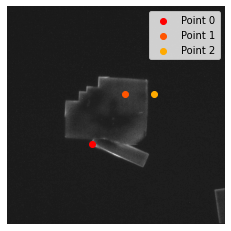

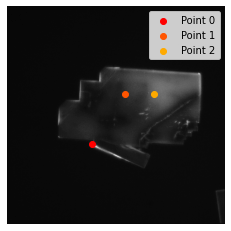

In [13]:
%matplotlib inline


plt.figure("Points location start")

image=images_2D[0].data[24][:][:] # could use better way of visualising
plt.imshow((image), cmap='Greys_r')

cmap = plt.cm.get_cmap('autumn') # use any colormap you like

for i in np.arange(len(points)):
    col = cmap(i/len(points)) # cmap takes float between 0 & 1 and returns corresponding color
    point = points[i]
    xcoord = point[0]
    ycoord = point[1]
    plt.scatter(xcoord, ycoord, color =col, label = "Point %i" %i)
plt.legend()
plt.axis("off")
plt.show()

plt.figure("Points location end")

image=images_2D[-1].data[24][:][:] # could use better way of visualising
plt.imshow((image), cmap='Greys_r')

cmap = plt.cm.get_cmap('autumn') # use any colormap you like

for i in np.arange(len(points)):
    col = cmap(i/len(points)) # cmap takes float between 0 & 1 and returns corresponding color
    point = points[i]
    xcoord = point[0]
    ycoord = point[1]
    plt.scatter(xcoord, ycoord, color =col, label = "Point %i" %i)
plt.legend()
plt.axis("off")
plt.show()

In [14]:
def extract_peak_wavelength(image_1d, wavelengths, point):
    """
    Point expected as x,y of indices even though how index into data is [y][x]
    Might consider making average of pixels nearby rather than peak from 1.
    
    I think to make work better need to make index finding better, will reduce noise I think when there are multiple. Or could replace with Gaussian location fitting?
    """
    # Extract spectra from data.
    x = point[0]
    y = point[1]
    pixel_spectra = image_1d.data[y][x]
    
    # Just basic but robust peak wavelength for now
    max_intensity = np.max(pixel_spectra)
    index = np.where(pixel_spectra == max_intensity)[0][0] # could make more refined so if multiple indices of max value can just say no peak or broad or average.
    peak_lam = wavelengths[index]
    return peak_lam

In [15]:
peak_lam_series_for_points=[]
for point in points:
    peak_lam_series = []
    for image_1d in images_1D:
        peak_lam=extract_peak_wavelength(image_1d, wavelengths, point)
        peak_lam_series.append(peak_lam)
    peak_lam_series_for_points.append(peak_lam_series)

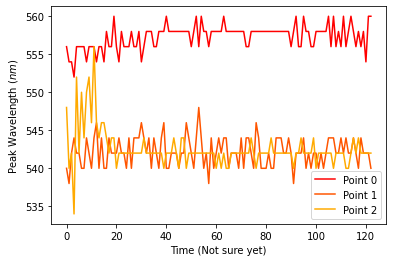

In [24]:
%matplotlib inline

cmap = plt.cm.get_cmap('autumn') # use any colormap you like

plot_indices = [0,1,2] # include indices of items want plotted

for i in np.arange(len(points)):
    if i in plot_indices:
        col = cmap(i/len(points)) # cmap takes float between 0 & 1 and returns corresponding color
        plt.plot(ts, peak_lam_series_for_points[i], color =col, label = "Point %i" %i)
plt.xlabel("Time (Not sure yet)")
plt.ylabel("Peak Wavelength ($nm$)")
plt.legend()
plt.show()

## Unsupervised Machine Learning

Select which time steps to look at.

In [27]:
selected_indices = [0, int(np.rint(len(images_1D)/2)),-1]

[0, 62, -1]

Perform single value decomposition.

### Single Time Step Inspection

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


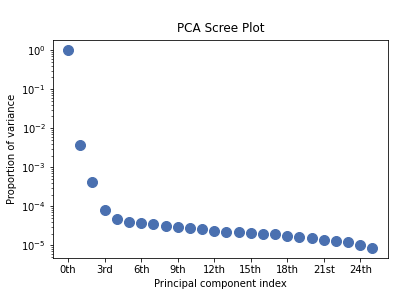

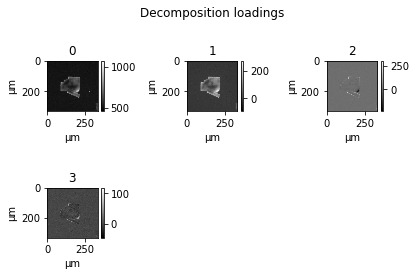

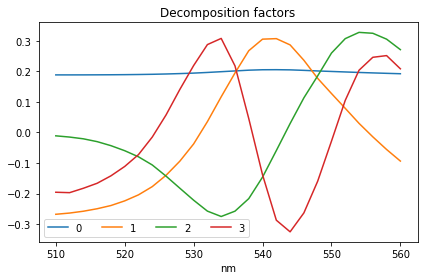

In [31]:
im_1d=images_1D[0].copy()

svd = im_1d.decomposition()
im_1d.plot_explained_variance_ratio()
im_1d.plot_decomposition_loadings(comp_ids=4) # look at relevant sections of the image
im_1d.plot_decomposition_factors(comp_ids=4) # look at corresponding spectra
plt.show()

In [32]:
im_1d.decomposition(algorithm="NMF", output_dimension=4)

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=NMF
  output_dimension=4
  centre=None
scikit-learn estimator:
NMF(n_components=4)


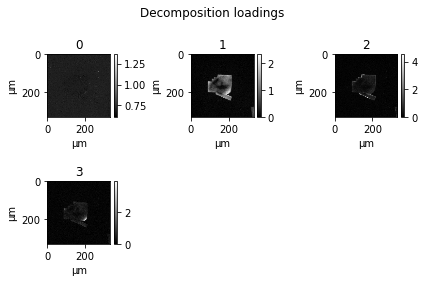

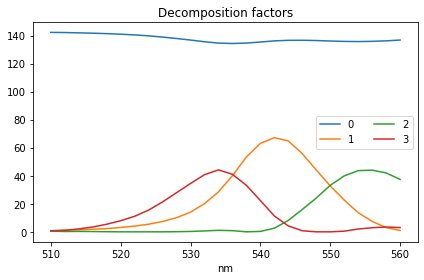

In [41]:
%matplotlib inline
# set the number of components to whatever looks sensible from the scree plot
im_1d.plot_decomposition_loadings(comp_ids=4) # look at relevant sections of the image
im_1d.plot_decomposition_factors(comp_ids=4) # look at corresponding spectra
plt.show()

### Multiple Time Step Investigation

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None
Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None
Decomposition info:
  normalize_poissonian_noise=False
  algorithm=SVD
  output_dimension=None
  centre=None


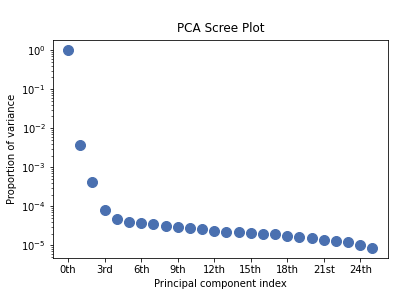

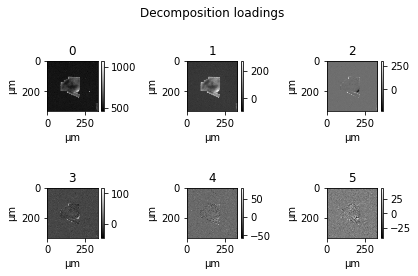

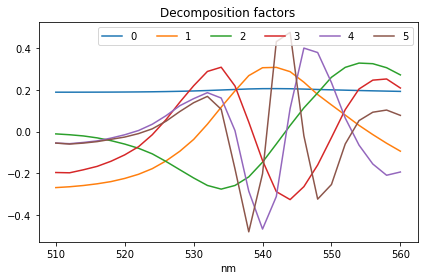

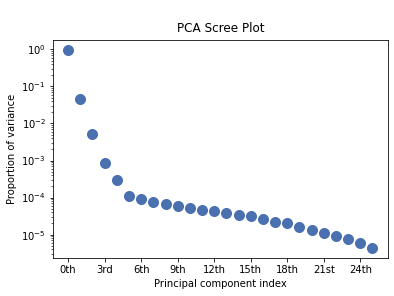

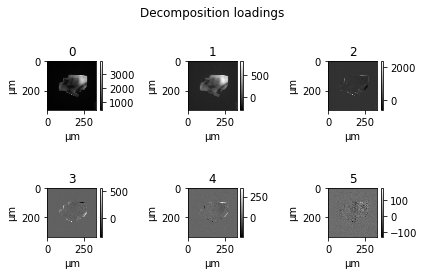

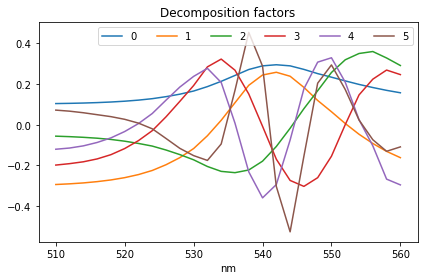

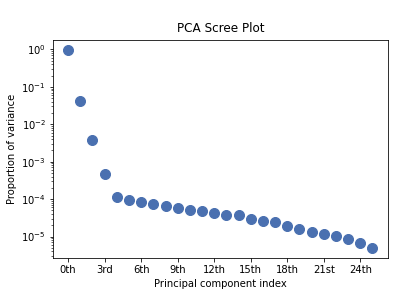

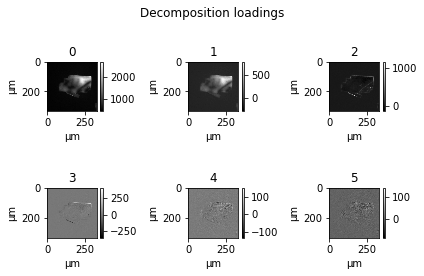

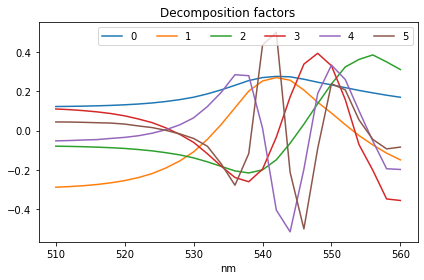

In [30]:
images_1D_copy = images_1D.copy()

significant_components = 6

for index in selected_indices:
    signal_1d = images_1D_copy[index]
    signal_1d.decomposition()
    signal_1d.plot_explained_variance_ratio()
    signal_1d.plot_decomposition_loadings(comp_ids=significant_components)
    signal_1d.plot_decomposition_factors(comp_ids=significant_components)

Decomposition info:
  normalize_poissonian_noise=False
  algorithm=NMF
  output_dimension=6
  centre=None
scikit-learn estimator:
NMF(n_components=6)
Decomposition info:
  normalize_poissonian_noise=False
  algorithm=NMF
  output_dimension=6
  centre=None
scikit-learn estimator:
NMF(n_components=6)
Decomposition info:
  normalize_poissonian_noise=False
  algorithm=NMF
  output_dimension=6
  centre=None
scikit-learn estimator:
NMF(n_components=6)


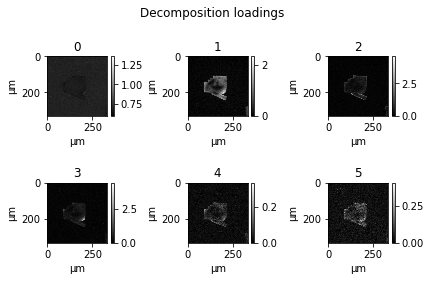

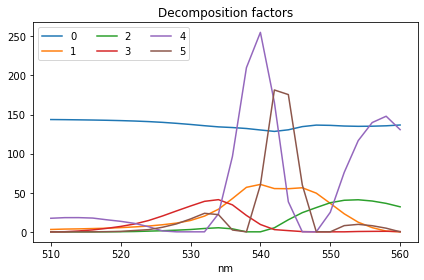

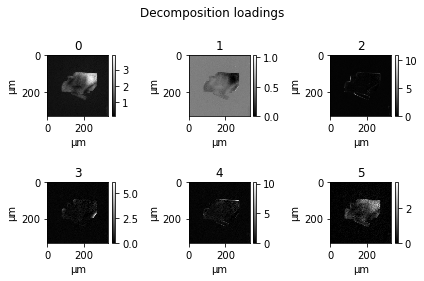

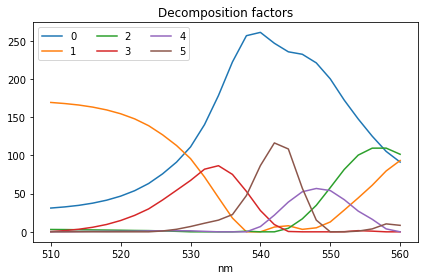

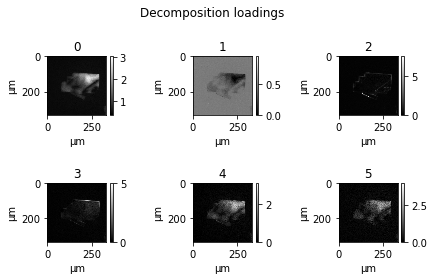

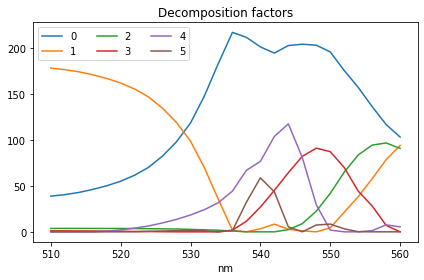

In [43]:
for index in selected_indices:
    signal_1d = images_1D_copy[index]
    signal_1d.decomposition(algorithm="NMF", output_dimension=significant_components)
    signal_1d.plot_decomposition_loadings(comp_ids=significant_components)
    signal_1d.plot_decomposition_factors(comp_ids=significant_components)